# Market Analysis & Fraud Detection

In [7]:
import pandas as pd

trades = pd.read_csv('trades.csv')
activity = pd.read_csv('user_activitycsv.csv')

trades.shape, activity.shape

((2324, 6), (4845, 5))

In [8]:
trades.head()

,pair,amount,volume,side,timestamp,user_id
0,AAVENGN,500.26,0.001222,buy,2024-12-03T01:42:07.072672Z,541-1561-1521-1561-148
1,ADANGN,889.20,0.500000,sell,2024-12-02T11:29:56.860014Z,491-1541-1521-1571-156
2,ADANGN,30653.12,17.100000,sell,2024-11-30T05:25:49.99166Z,1021-1481-1521-1561-1100
3,ADANGN,1978.36,1.100000,sell,2024-12-07T07:41:02.191598Z,981-1571-1521-1971-151
4,ADANGN,2913.62,1.600000,sell,2024-12-07T21:16:11.791118Z,981-1571-1521-1971-151


In [9]:
activity.head()

,asset,amount,activity_type,timestamp,user_id
0,NGN,131062.0,withdrawal,2025-01-17T14:37:56.806446Z,561-1561-1521-1981-1101
1,NGN,50000.0,withdrawal,2025-01-17T14:37:56.818033Z,971-11001-1521-1571-1101
2,NGN,131062.0,deposit,2025-01-17T14:37:56.853225Z,481-11011-1521-1971-1100
3,NGN,20064.0,withdrawal,2025-01-17T17:05:18.201218Z,531-11001-1521-1571-198
4,NGN,2000.0,withdrawal,2025-01-17T14:38:22.555744Z,501-11021-1521-1561-154


In [10]:
trades['timestamp'] = pd.to_datetime(trades['timestamp'])
activity['timestamp'] = pd.to_datetime(activity['timestamp'])

In [11]:
trades.dtypes

pair                      object
amount                   float64
volume                   float64
side                      object
timestamp    datetime64[ns, UTC]
user_id                   object
dtype: object

In [12]:
activity.dtypes

asset                         object
amount                       float64
activity_type                 object
timestamp        datetime64[ns, UTC]
user_id                       object
dtype: object

In [13]:
trades.isna().sum()

pair         0
amount       0
volume       0
side         0
timestamp    0
user_id      0
dtype: int64

### Data Notes & Assumptions
- Trade `amount` represents total trade value in quote currency.
- Prices are not explicitly provided; volume-based calculations use `amount`.
- Timestamps are ISO-formatted and converted directly to datetime.


# 1. Exploratory Data Analysis & Market Insights
## 1.1 Market Dynamics (Top 3 Most Traded Pairs (USD))

In [15]:
USD_RATE = 1500

trades['usd_volume'] = trades['amount'] / USD_RATE

top_pairs = (
    trades.groupby('pair')['usd_volume']
    .sum()
    .sort_values(ascending=False)
    .head(3)
)

top_pairs


pair
BTCNGN     136215.488680
USDTNGN     59180.573580
ETHNGN       9764.589513
Name: usd_volume, dtype: float64

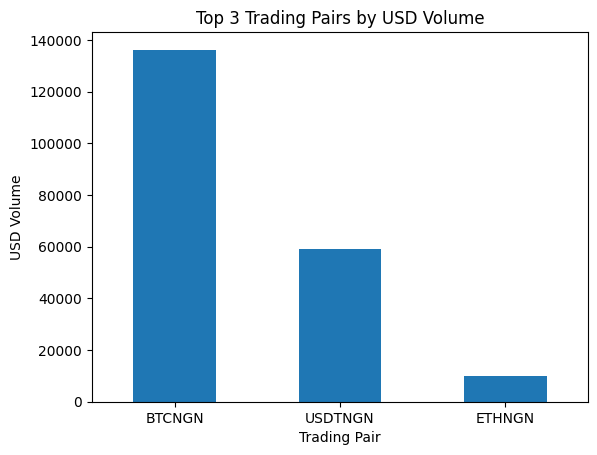

In [16]:
import matplotlib.pyplot as plt

top_pairs.plot(kind='bar', title='Top 3 Trading Pairs by USD Volume')
plt.ylabel('USD Volume')
plt.xlabel('Trading Pair')
plt.xticks(rotation=0)
plt.show()


**Insight:**  
The top 3 trading pairs are BTCNGN, USDTNGN, and ETHNGN. BTCNGN dominates total USD volume, indicating it is the most liquid pair on the platform, followed by stablecoin USDTNGN and ETHNGN. This shows liquidity is concentrated in a few major pairs.


## 1.2 Volatility Analysis


In [18]:
btc = trades[trades['pair'] == 'BTCNGN'].copy()
btc['price'] = btc['amount']/btc['volume']

In [19]:
btc[['timestamp', 'price']].head()

,timestamp,price
98,2024-12-04 12:08:08.522367+00:00,1.513219e+08
99,2024-12-02 11:09:55.042640+00:00,1.553334e+08
100,2024-11-28 16:06:43.218713+00:00,1.577873e+08
101,2024-11-27 21:17:00.288607+00:00,1.608095e+08
102,2024-12-10 13:39:00.085610+00:00,1.533132e+08


In [20]:
btc['date'] = btc['timestamp'].dt.date
daily_vol = btc.groupby('date')['price'].std()
rolling_vol = daily_vol.rolling(7).mean()

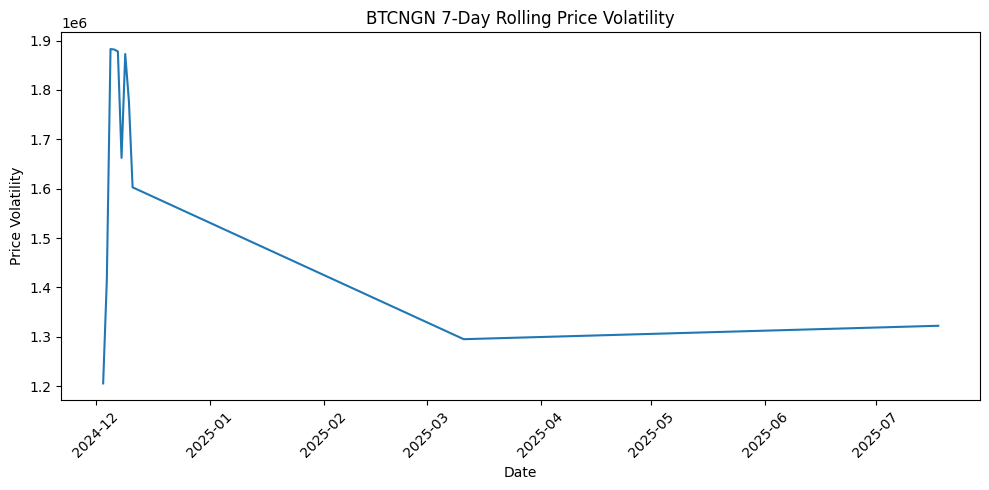

In [24]:
plt.figure(figsize=(10,5))
rolling_vol.plot(title='BTCNGN 7-Day Rolling Price Volatility')
plt.ylabel('Price Volatility')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Insight:**  
The 7-day rolling volatility of BTCNGN shows periods of high and low price fluctuation. Peaks indicate high market activity or uncertainty, while troughs indicate stability. This insight can help in risk management, spread adjustments, and trading strategy planning.


## 1.3 User Behaviour (Peak Deposit Times)

In [25]:
deposits = activity[activity['activity_type'] == 'deposit'].copy()
deposits['hour'] = deposits['timestamp'].dt.hour
deposits['weekday'] = deposits['timestamp'].dt.day_name()


In [26]:
# Count deposits per hour
hourly = deposits.groupby('hour').size()

# Count deposits per weekday (ensure correct order)
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekday = deposits.groupby('weekday').size().reindex(weekday_order)


### Plot Deposits by Hour

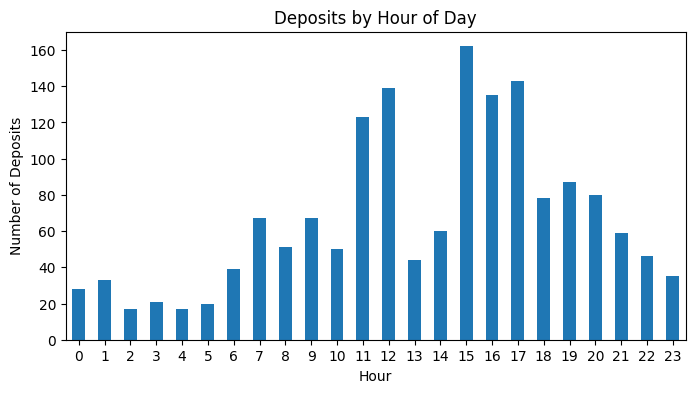

In [27]:
plt.figure(figsize=(8,4))
hourly.plot(kind='bar', title='Deposits by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Deposits')
plt.xticks(rotation=0)
plt.show()


### Plot Deposits by Day of Week

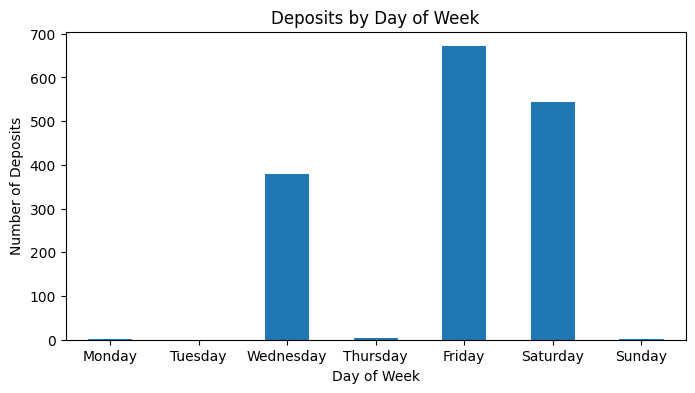

In [28]:
plt.figure(figsize=(8,4))
weekday.plot(kind='bar', title='Deposits by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Deposits')
plt.xticks(rotation=0)
plt.show()


**Insight:**  
Deposits peak during specific hours and weekdays, indicating when users are most active. Marketing campaigns, customer support, or system maintenance can be timed around these periods to maximize engagement and minimize disruption.


# Part 2: Fraud Detection Model
## Step 1: Feature Engineering

### 1. Deposit & Withdrawal Features

In [29]:
# Pivot activity to get counts
act_feat = activity.pivot_table(
    index='user_id',
    columns='activity_type',
    values='asset',
    aggfunc='count'
).fillna(0)

# Rename columns
act_feat.columns = ['deposit_count', 'withdrawal_count']

# Withdrawal ratio
act_feat['withdrawal_ratio'] = act_feat['withdrawal_count'] / (act_feat['deposit_count'] + 1)


### 2. Time Between First Deposit and First Withdrawal

In [30]:
first_dep = activity[activity['activity_type']=='deposit'].groupby('user_id')['timestamp'].min()
first_wd = activity[activity['activity_type']=='withdrawal'].groupby('user_id')['timestamp'].min()

time_diff = (first_wd - first_dep).dt.total_seconds() / 3600  # in hours

act_feat['hours_to_withdraw'] = time_diff.fillna(0)


### 3. Trading Features

In [33]:
trade_feat = trades.groupby('user_id').agg({
    'amount':'sum',       # total USD-equivalent volume
    'pair':'nunique'      # number of unique trading pairs
}).rename(columns={'amount':'total_traded', 'pair':'unique_pairs'})

# Merge all features
features = act_feat.join(trade_feat, how='left').fillna(0)
features.head()


,deposit_count,withdrawal_count,withdrawal_ratio,hours_to_withdraw,total_traded,unique_pairs
user_id,,,,,,
1001-11001-1521-1561-154,3.0,20.0,5.00,-2.692500,27484.11,1
1001-11001-1521-1571-155,1.0,1.0,0.50,0.380501,71703.21,1
1001-11001-1521-1971-1102,1.0,1.0,0.50,0.563419,70009.30,1
1001-11001-1521-1971-156,0.0,1.0,1.00,0.000000,3334.62,1
1001-11001-1521-1981-156,7.0,6.0,0.75,-0.032768,7410.24,1


## Step 2. Target Labeling 



### Rule-Based Fraud Labeling 
**We define suspicious users as:**

- Withdrawal ratio > 0.8

- Hours to first withdrawal < 24

- Very low trading relative to deposits (less than 50 USD per deposit)

In [66]:
features['suspicious'] = (
    (features['withdrawal_ratio'] > 0.2) &
    (features['hours_to_withdraw'] < 96) &
    (features['total_traded'] < features['deposit_count'] * 1000)
).astype(int)


In [70]:
# Check distribution
features['suspicious'].value_counts()
# print("Suspicious label distribution:\n", features['suspicious'].value_counts())


suspicious
0    1187
1      12
Name: count, dtype: int64

## Step 3: Model Building

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

X = features.drop(columns='suspicious')
y = features['suspicious']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Train Random Forest

model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'  # helps handle the imbalance
)
model.fit(X_train, y_train)

# model = RandomForestClassifier(n_estimators=200, random_state=42)
# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)



,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

## Make Predictions

In [62]:
y_pred = model.predict(X_test)
y_pred[:10]  # shows the first 10 predictions


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Step 4: Model Evaluation

In [73]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision:', precision_score(y_test, y_pred, zero_division=0))
print('Recall:', recall_score(y_test, y_pred, zero_division=0))
print('F1 Score:', f1_score(y_test, y_pred, zero_division=0))


Precision: 0.0
Recall: 0.0
F1 Score: 0.0


In [65]:
# Check Positive Samples
print("y_train distribution:\n", y_train.value_counts())
print("y_test distribution:\n", y_test.value_counts())


y_train distribution:
 suspicious
0    831
1      8
Name: count, dtype: int64
y_test distribution:
 suspicious
0    356
1      4
Name: count, dtype: int64


In [72]:
# Count Predictions
import numpy as np
np.bincount(y_pred)  # shows how many 0s and 1s were predicted


array([359,   1])

In [74]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision:', precision_score(y_test, y_pred, zero_division=0))
print('Recall:', recall_score(y_test, y_pred, zero_division=0))
print('F1 Score:', f1_score(y_test, y_pred, zero_division=0))


Precision: 0.0
Recall: 0.0
F1 Score: 0.0


**Note:**  
The dataset is extremely imbalanced (12 positives out of ~1200 users).  
As a result, the Random Forest model predicts very few positives, and metrics like Precision, Recall, and F1 are zero.  
This demonstrates the workflow. In a production environment, additional data, relaxed labeling thresholds, or oversampling techniques (e.g., SMOTE) would be applied to improve detection.


# Part 3: Strategic Recommendation

**Question:**  
The product team wants to launch a 'Low-Volume Trader' marketing campaign in
Kenya. Using the data, how would you define the target audience for this campaign? Describe
2-3 data points you would use to create this user segment.

**Objective:**  
The product team wants to target "Low-Volume Traders" in Kenya for a marketing campaign. Based on the data, the target audience can be defined as users who trade infrequently and in small amounts.

**User Segment Definition:**  
1. **Low Trading Volume:** Users whose total traded amount is below a certain threshold (e.g., less than $500 USD equivalent).  
2. **Few Trades:** Users with a small number of trades or unique trading pairs, indicating minimal activity.  
3. **Deposit Behavior:** Users who deposit occasionally but do not withdraw large amounts frequently, signaling engagement potential without high risk.

**Data Points to Use:**  
- `total_traded`: Total amount traded by the user across all pairs.  
- `unique_pairs` or `trade_count`: Number of different trading pairs or total trades executed.  
- `deposit_count` or `withdrawal_count`: Frequency of deposits and withdrawals to assess engagement and potential responsiveness to promotions.

**Marketing Implication:**  
By targeting users with low trading volume and minimal activity, the campaign can encourage these users to increase trading activity, improving liquidity and retention while keeping risk manageable.
